In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

seed = 42

In [2]:
data_path = './data/german.data-numeric'
credit = np.genfromtxt(data_path)

print(credit)

[[ 1.  6.  4. ...  0.  1.  1.]
 [ 2. 48.  2. ...  0.  1.  2.]
 [ 4. 12.  4. ...  1.  0.  1.]
 ...
 [ 4. 12.  2. ...  0.  1.  1.]
 [ 1. 45.  2. ...  0.  1.  2.]
 [ 2. 45.  4. ...  0.  1.  1.]]


In [3]:
X = credit[:, :-1]
y = credit[:, -1]

print(X.shape, y.shape)

(1000, 24) (1000,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

print(X_train.shape, y_train.shape)

(800, 24) (800,)


In [5]:
DT = DecisionTreeClassifier(random_state = seed)
RF = RandomForestClassifier(random_state = seed)

In [6]:
print('Demo DT prediction:')

DT.fit(X_train, y_train)
y_dt_pred = DT.predict(X_test)

print("DT acc = {}".format(accuracy_score(y_test, y_dt_pred)))
print("DT f1 = {}".format(f1_score(y_test, y_dt_pred)))
print("DT roc auc = {}".format(roc_auc_score(y_test, y_dt_pred)))
print(confusion_matrix(y_test, y_dt_pred))

Demo DT prediction:
DT acc = 0.665
DT f1 = 0.7632508833922261
DT roc auc = 0.5948431301839163
[[108  33]
 [ 34  25]]


In [7]:
print(classification_report(y_test, y_dt_pred))

              precision    recall  f1-score   support

         1.0       0.76      0.77      0.76       141
         2.0       0.43      0.42      0.43        59

    accuracy                           0.67       200
   macro avg       0.60      0.59      0.60       200
weighted avg       0.66      0.67      0.66       200



In [8]:
print('Demo RF prediction:')

RF.fit(X_train, y_train)
y_rf_pred = RF.predict(X_test)

print("RF acc = {}".format(accuracy_score(y_test, y_rf_pred)))
print("RF f1 = {}".format(f1_score(y_test, y_rf_pred)))
print("RF roc auc = {}".format(roc_auc_score(y_test, y_rf_pred)))
print(confusion_matrix(y_test, y_rf_pred))


Demo RF prediction:
RF acc = 0.81
RF f1 = 0.875
RF roc auc = 0.7173939175381656
[[133   8]
 [ 30  29]]


In [9]:
print(classification_report(y_test, y_rf_pred))

              precision    recall  f1-score   support

         1.0       0.82      0.94      0.88       141
         2.0       0.78      0.49      0.60        59

    accuracy                           0.81       200
   macro avg       0.80      0.72      0.74       200
weighted avg       0.81      0.81      0.80       200



In [10]:
def grid_search(algorithm, n_jobs, dict_param):
    
    if algorithm == 'decision-tree':
        model = DecisionTreeClassifier()
    else:
        model = RandomForestClassifier()
        
    classifier = GridSearchCV(estimator = model, cv = 5, param_grid = dict_param, n_jobs = n_jobs, scoring = 'f1', verbose = 1)
    classifier.fit(X_train, y_train)
    
    print(classifier.best_estimator_)
    return classifier.best_estimator_

In [11]:
def evaluate(model):
    
    print("Train Accuracy :", accuracy_score(y_train, model.predict(X_train)))
    print("Train f1 score :", f1_score(y_train, model.predict(X_train)))
    print("Train roc auc :", roc_auc_score(y_train, model.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, model.predict(X_train)))
    
    print("-" * 50)
    
    print("Test Accuracy :", accuracy_score(y_test, model.predict(X_test)))
    print("Test f1 score :", f1_score(y_test, model.predict(X_test)))
    print("Test roc auc :", roc_auc_score(y_test, model.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, model.predict(X_test)))

In [12]:
def plot_learning_curve(estimator, title, label_curve, X, y, ylim = None, cv = None, n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5), new_plot = False, idx_color = 0):
    if new_plot:
        plt.title(title)
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.grid()
        
    if ylim != None:
        plt.ylim(*ylim)
        
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes, scoring = "f1")
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'r')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'g')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'r', label = label_curve['test'])
    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'g', label = label_curve['train'])

    plt.legend(loc = "best")
    return plt

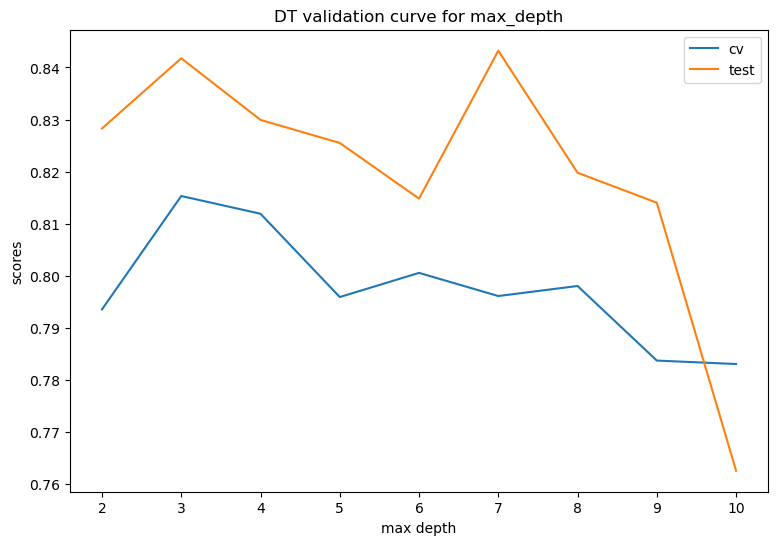

In [13]:
cv_accuracy = []
test_accuracy = []

max_depth_values = np.arange(2, 11)

for k in max_depth_values:
    DT = DecisionTreeClassifier(random_state = seed, max_depth = k)
    cv_score = cross_val_score(estimator = DT, X = X_train, y = y_train, cv = 5, scoring = 'f1')
    cv_accuracy.append(cv_score.mean())

    DT.fit(X_train, y_train)
    y_pred = DT.predict(X_test)
    test_accuracy.append(f1_score(y_pred, y_test))

plt.figure(figsize = (9, 6))
plt.plot(max_depth_values, cv_accuracy, label = 'cv')
plt.plot(max_depth_values, test_accuracy, label = 'test')
plt.title('DT validation curve for max_depth')
plt.xlabel('max depth')
plt.ylabel('scores')
plt.legend()
plt.show()

In [14]:
dict_param = {
    'max_depth': [2, 3, 4, 5, 7, 10, 13, 15, 17, 25],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [5, 10, 20, 50, 100, 200],
    'max_leaf_nodes': [None, 5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"],
    'class_weight': ["balanced"],
}
tree_best = grid_search('decision-tree', n_jobs = -1, dict_param = dict_param)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits
DecisionTreeClassifier(class_weight='balanced', max_depth=10, max_leaf_nodes=20,
                       min_samples_leaf=10)


In [15]:
tree_best.fit(X_train, y_train)
evaluate(tree_best)

Train Accuracy : 0.765
Train f1 score : 0.8174757281553398
Train roc auc : 0.7728308553359213
Train Confusion Matrix:
[[421 138]
 [ 50 191]]
--------------------------------------------------
Test Accuracy : 0.655
Test f1 score : 0.7272727272727273
Test roc auc : 0.6567496093280443
Test Confusion Matrix:
[[92 49]
 [20 39]]


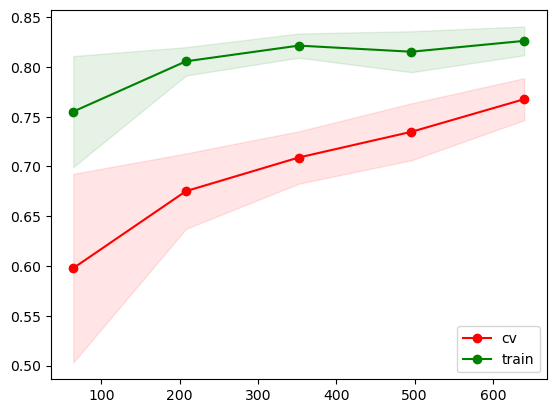

In [16]:
title = 'Learning curve with best tree'
label_curve = {'train': 'train', 'test': 'cv'}
plot_learning_curve(tree_best, title, label_curve, X_train, y_train)
plt.show()

In [17]:
importances = tree_best.feature_importances_
indices = np.argsort(importances)[::-1]

print('Top 10 feature importances')

for i in range(10):
    print('Feature ', i, '-', importances[indices[i]])

Top 10 feature importances
Feature  0 - 0.3906504684169838
Feature  1 - 0.11809589349636704
Feature  2 - 0.09419678711185363
Feature  3 - 0.0831545291787223
Feature  4 - 0.067427489076478
Feature  5 - 0.06628468680629578
Feature  6 - 0.06585829282013725
Feature  7 - 0.03257685560890739
Feature  8 - 0.026073469649263433
Feature  9 - 0.020907873270382158


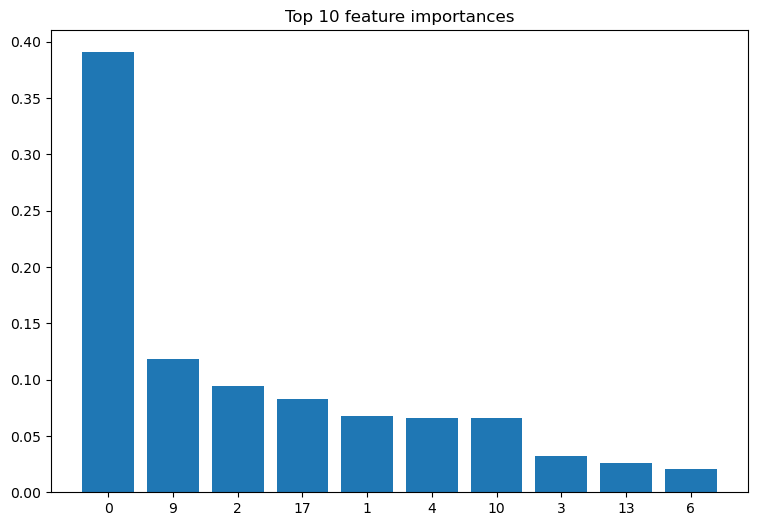

In [18]:
indices = indices[:10]
plt.figure(figsize = (9, 6))
plt.title('Top 10 feature importances')
plt.bar(range(10), importances[indices])
plt.xticks(range(10), indices)
plt.show()

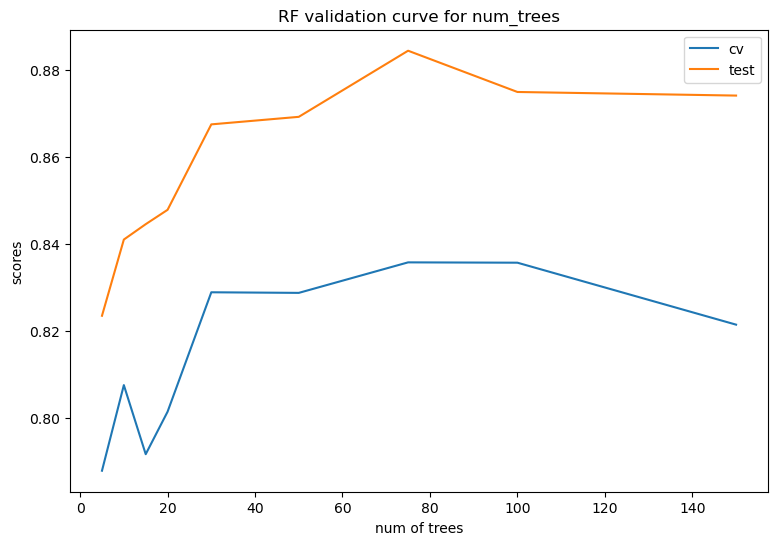

In [19]:
num_trees = [5, 10, 15, 20, 30, 50, 75, 100, 150]

cv_accuracy = []
test_accuracy = []

for n in num_trees:
    RF = RandomForestClassifier(n_estimators = n, random_state = seed, n_jobs = -1)
    RF.fit(X_train, y_train)
    cv_score = cross_val_score(estimator = RF, X = X_test, y = y_test, cv = 5, scoring = 'f1')
    cv_accuracy.append(cv_score.mean())

    y_pred = RF.predict(X_test)
    test_accuracy.append(f1_score(y_pred, y_test))

plt.figure(figsize = (9, 6))
plt.plot(num_trees, cv_accuracy, label = 'cv')
plt.plot(num_trees, test_accuracy, label = 'test')
plt.title('RF validation curve for num_trees')
plt.xlabel('num of trees')
plt.ylabel('scores')
plt.legend()
plt.show()

In [ ]:
dict_param = {
    'n_estimators': [5, 10, 15, 20, 30, 50, 75, 100, 200, 400],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [5, 10, 20, 50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'criterion': ["gini", "entropy"],
    'class_weight': ["balanced"],
}
tree_best = grid_search('random-forest', n_jobs = -1, dict_param = dict_param)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


In [ ]:
tree_best.fit(X_train, y_train)
evaluate(tree_best)

In [ ]:
importances = tree_best.feature_importances_
indices = np.argsort(importances)[::-1]

print('Top 10 feature importances')

for i in range(10):
    print('Feature ', i, '-', importances[indices[i]])

In [ ]:
title = 'Learning curve with best tree'
label_curve = {'train': 'train', 'test': 'cv'}
plot_learning_curve(tree_best, title, label_curve, X_train, y_train)
plt.show()

In [ ]:
indices = indices[:10]
plt.figure(figsize = (9, 6))
plt.title('Top 10 feature importances')
plt.bar(range(10), importances[indices])
plt.xticks(range(10), indices)
plt.show()

In [ ]:
sfm = SelectFromModel(tree_best, threshold = 'mean')
sfm.fit(X_train, y_train)

X_train_dropped = sfm.transform(X_train)
X_test_dropped = sfm.transform(X_test)

title = 'Learning with dropped features'
label_curve = {'train': 'train', 'test':'cv'}

forest_dropped = RandomForestClassifier(max_depth = 11, min_samples_leaf = 5,
                                        n_estimators = 75, n_jobs = -1, random_state = seed)

forest_dropped.fit(X_train_dropped, y_train)
y_dropped_pred = forest_dropped.predict(X_test_dropped)

print('acc', accuracy_score(y_test, y_dropped_pred))
print('f1', f1_score(y_test, y_dropped_pred))
print('roc_auc', roc_auc_score(y_test, y_dropped_pred))

In [ ]:
plot_learning_curve(forest_dropped, title, label_curve, X_train_dropped, y_train, cv = 5)
plt.show()

In [ ]:
params = {
    'max_depth': tree_best.get_params()['max_depth'],
    'max_features': tree_best.get_params()['max_features'],
    'min_samples_leaf': tree_best.get_params()['min_samples_leaf'],
    'n_estimators': tree_best.get_params()['n_estimators']
}

evaluate(tree_best)

In [ ]:
rf1 = RandomForestClassifier(max_depth = params['max_depth'],
                             max_features = params['max_features'],
                             min_samples_leaf = params['min_samples_leaf'],
                             n_estimators = params['n_estimators'],
                             class_weight = 'balanced')
rf1.fit(X_train, y_train)
evaluate(rf1)

In [ ]:
rf2 = RandomForestClassifier(max_depth = params['max_depth'],
                             max_features = params['max_features'],
                             min_samples_leaf = params['min_samples_leaf'],
                             n_estimators = params['n_estimators'],
                             class_weight = 'balanced_subsample')
rf2.fit(X_train, y_train)
evaluate(rf2)

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

rf3 = BalancedRandomForestClassifier(max_depth = params['max_depth'],
                                     max_features = params['max_features'],
                                     min_samples_leaf = params['min_samples_leaf'],
                                     n_estimators = params['n_estimators']
)

rf3.fit(X_train, y_train)
evluate(rf3)